# Marigold: Repurposing Diffusion-Based Image Generators for Monocular Depth Estimation

[![Website](https://img.shields.io/badge/Project-Website-1081c2)](https://arxiv.org/abs/2312.02145)
[![GitHub](https://img.shields.io/github/stars/prs-eth/Marigold?style=default&label=GitHub%20★&logo=github)](https://github.com/prs-eth/Marigold)
[![Paper](https://img.shields.io/badge/arXiv-PDF-b31b1b)](https://arxiv.org/abs/2312.02145)
[![Hugging Face Space](https://img.shields.io/badge/🤗%20Hugging%20Face-Space-yellow)](https://huggingface.co/spaces/prs-eth/marigold)
[![Hugging Face Model](https://img.shields.io/badge/🤗%20Hugging%20Face-Model-green)](https://huggingface.co/prs-eth/marigold-depth-v1-0)
[![License](https://img.shields.io/badge/License-Apache--2.0-929292)](https://www.apache.org/licenses/LICENSE-2.0)

![Teaser](https://share.phys.ethz.ch/~pf/bingkedata/marigold/static/teaser_collage_transparant.png)



The necessary code to run [Marigold](https://marigoldmonodepth.github.io) is present in this notebook, using google's hardware.

Last updated: 2024-03-28


### To execute a cell, click the *play* button in front.

---

# 🛠️ 1 Setup

In [1]:
# @title 💻 1.1 Check CUDA and Python Version (tested with CUDA 12.2 + Python 3.10.12)

# This notebook is supposed to be connected to NVIDIA drivers with CUDA.
# If this doesn't load check that GPU is selected as hardware accelerator under Edit -> Notebook settings.
!nvidia-smi
!python -V

Mon May 12 01:53:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# @title 1.2 👆 Select Checkpoint
!pip install ipywidgets==7.7.1 --quiet

from IPython.display import display
import ipywidgets as widgets
import shutil

ckpt_dic = {
    "Original (higher quality)": "prs-eth/marigold-v1-0",
    "LCM (faster)": "prs-eth/marigold-lcm-v1-0",
}

ckpt_name = 'LCM (faster)'
ckpt_path = ckpt_dic[ckpt_name]
w = widgets.Dropdown(
    options=['Original (higher quality)', 'LCM (faster)'],
    value=ckpt_name,
    description='Checkpoint:',
)


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        ckpt_name = change['new']
        ckpt_path = ckpt_dic[ckpt_name]
        # print(f"Change to checkpoint: {ckpt_name} ({ckpt_path})")

w.observe(on_change)

display(w)
# print(f"{ckpt_path = }")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.5 MB/s eta 0:00:00


Dropdown(description='Checkpoint:', index=1, options=('Original (higher quality)', 'LCM (faster)'), value='LCM…

## 1.3 🏗️ Installation and Initialization

We provide two ways to run the pipeline. You can choose either ONE to run:

### 🅱 1.3-A Using code from the [full repository](https://github.com/prs-eth/marigold)

In [3]:
# @title 📦 i. Clone repository

%%shell
cd /content

if [ -d "Marigold" ]; then
    cd Marigold
    git pull
else
    git clone https://github.com/prs-eth/Marigold.git
    cd Marigold
fi


Cloning into 'Marigold'...
remote: Enumerating objects: 897, done.
remote: Counting objects: 100% (555/555), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 897 (delta 353), reused 418 (delta 284), pack-reused 342 (from 1)
Receiving objects: 100% (897/897), 9.69 MiB | 12.40 MiB/s, done.
Resolving deltas: 100% (493/493), done.


In [22]:
# @title 🔨 ii. Install dependencies (might take minutes)
%%shell

cd /content/Marigold

# pip install -r requirements.txt --upgrade  --quiet
pip install accelerate diffusers matplotlib scipy torch transformers --quiet

# for progress bar
pip install ipywidgets==7.7.1 --quiet

#for eval
pip install omegaconf --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.1 MB/s eta 0:00:00


In [23]:
# @title 🔧 iii. Setup directories

import os

# Directories
repo_dir = "/content/Marigold"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_dir_color = os.path.join(output_dir, "depth_colored")
output_dir_tif = os.path.join(output_dir, "depth_bw")
output_dir_npy = os.path.join(output_dir, "depth_npy")

os.chdir(repo_dir)



In [24]:
# @title 🏇 iv. Initialize pipeline

# change model cache directory
# !export HF_HOME=/content/Marigold/checkpoint

from marigold import MarigoldPipeline

pipe = MarigoldPipeline.from_pretrained(ckpt_path)

pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

### 🅰 1.3-B Using [d🧨ffusers](https://github.com/huggingface/diffusers) [community pipeline](https://github.com/huggingface/diffusers/tree/main/examples/community#marigold-depth-estimation) (easiest, but might be updated slower)



In [ ]:
# @title 🔨 i. Install dependencies

!pip install --upgrade "diffusers>=0.25.0" --quiet

# !pip install ipywidgets==7.7.1 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.1 MB/s eta 0:00:00


In [ ]:
# @title 🔧 ii. Setup directories
import os


# Directories
repo_dir = "/content/Marigold"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_dir_color = os.path.join(output_dir, "depth_colored")
output_dir_tif = os.path.join(output_dir, "depth_bw")
output_dir_npy = os.path.join(output_dir, "depth_npy")


os.makedirs(repo_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

os.chdir(repo_dir)

In [ ]:
# @title 🏇 iii. Initialize pipeline

# change model cache directory
!export HF_HOME=$(pwd)/checkpoint

from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    ckpt_path,
    custom_pipeline="marigold_depth_estimation"
)

pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:80: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


model_index.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


(…)s/community/marigold_depth_estimation.py:   0%|          | 0.00/6.49k [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## 🚀 2 Inference

In [11]:
# @title 🖼️ 2.2.2 Prepare input data: Upload input images to "input/" folder or use our sample images (run this cell to see buttons)

from IPython.display import display
import ipywidgets as widgets
import shutil

from google.colab import files

button_download = widgets.Button(description="Use sample images")
button_upload = widgets.Button(description="⬆ Upload images")
button_clear_in = widgets.Button(description="♻ Clear input folder")
button_clear_out = widgets.Button(description="♻ Clear output folder")
out_box = widgets.Output()


def on_button_download_clicked(b):
    out_box.clear_output()
    os.chdir(repo_dir)
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)

    with out_box:
        print("downloading sample images")

    # download data
    !wget -nv --show-progress https://share.phys.ethz.ch/~pf/bingkedata/marigold/in-the-wild_example.tar
    # untar
    !tar -xf "in-the-wild_example.tar"
    !rm "in-the-wild_example.tar"
    !mv "in-the-wild_example" "input"

    with out_box:
        print("sample images are downloaded")


def on_button_upload_clicked(b):
    out_box.clear_output()
    os.makedirs(input_dir, exist_ok=True)
    os.chdir(input_dir)
    with out_box:
        uploaded = files.upload()
    os.chdir(repo_dir)

def on_button_clear_in_clicked(b):
    out_box.clear_output()
    shutil.rmtree(input_dir)
    os.makedirs(input_dir)
    with out_box:
        print("Input images are cleared")

def on_button_clear_out_clicked(b):
    out_box.clear_output()
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    with out_box:
        print("Output folder is cleared")

button_download.on_click(on_button_download_clicked)
button_upload.on_click(on_button_upload_clicked)
button_clear_in.on_click(on_button_clear_in_clicked)
button_clear_out.on_click(on_button_clear_out_clicked)

widgets.VBox([widgets.HBox([button_upload, button_download]),
              widgets.HBox([button_clear_in, button_clear_out]),
              out_box])


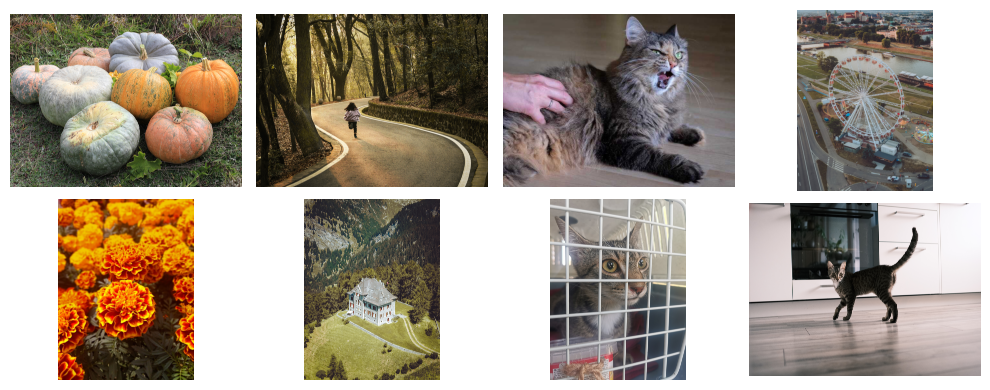

In [12]:
%matplotlib inline

# @title 2.2.3 Display input images

from glob import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Pre-defined function
def display_images(image_paths, n_images_per_row = 4):
    n_rows = math.ceil(len(image_paths) / n_images_per_row)

    plt.figure(figsize=(10, 2 * n_rows))  # Adjust the size as needed
    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        plt.subplot(n_rows, n_images_per_row, i + 1)  # Number of rows, number of images per row, current index
        plt.imshow(img)
        plt.axis('off')  # To not display axis

    plt.tight_layout()
    plt.show()


image_paths = glob(os.path.join(input_dir, "*"))

display_images(image_paths)

In [13]:
# @title ▶️ 2.2.4 Run inference (default settings are for LCM)
denoising_steps = 4 # @param {type:"integer"}
ensemble_size = 5 # @param {type:"integer"}
processing_res = 768 # @param {type:"integer"}
match_input_res = True # @param ["False", "True"]
# use_seed = True # @param ["False", "True"]
# seed = 2024 # @param {type:"integer"}

# if not use_seed:
#     seed = None

import logging
import numpy as np
import torch
from tqdm.auto import tqdm
from glob import glob
from PIL import Image


EXTENSION_LIST = [".jpg", ".jpeg", ".png"]

# Image list
rgb_filename_list = glob(os.path.join(input_dir, "*"))
rgb_filename_list = [
    f for f in rgb_filename_list if os.path.splitext(f)[1].lower() in EXTENSION_LIST
]
rgb_filename_list = sorted(rgb_filename_list)

# Create output folders
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_color, exist_ok=True)
os.makedirs(output_dir_tif, exist_ok=True)
os.makedirs(output_dir_npy, exist_ok=True)

# Run Inference
with torch.no_grad():
    os.makedirs(output_dir, exist_ok=True)

    for rgb_path in tqdm(rgb_filename_list, desc=f"Estimating depth", leave=True):
        # Read input image
        input_image = Image.open(rgb_path)

        # Predict depth
        pipeline_output = pipe(
            input_image,
            denoising_steps=denoising_steps,     # optional
            ensemble_size=ensemble_size,       # optional
            processing_res=processing_res,     # optional
            match_input_res=match_input_res,   # optional
            batch_size=0,           # optional
            color_map="Spectral",   # optional
            show_progress_bar=True, # optional
            # seed=seed,              # optional
        )

        depth_pred: np.ndarray = pipeline_output.depth_np
        depth_colored: Image.Image = pipeline_output.depth_colored

        # Save as npy
        rgb_name_base = os.path.splitext(os.path.basename(rgb_path))[0]
        pred_name_base = rgb_name_base + "_pred"
        npy_save_path = os.path.join(output_dir_npy, f"{pred_name_base}.npy")
        if os.path.exists(npy_save_path):
            logging.warning(f"Existing file: '{npy_save_path}' will be overwritten")
        np.save(npy_save_path, depth_pred)

        # Save as 16-bit uint png
        depth_to_save = (depth_pred * 65535.0).astype(np.uint16)
        png_save_path = os.path.join(output_dir_tif, f"{pred_name_base}.png")
        if os.path.exists(png_save_path):
            logging.warning(f"Existing file: '{png_save_path}' will be overwritten")
        Image.fromarray(depth_to_save).save(png_save_path, mode="I;16")

        # Colorize
        colored_save_path = os.path.join(
            output_dir_color, f"{pred_name_base}_colored.png"
        )
        if os.path.exists(colored_save_path):
            logging.warning(f"Existing file: '{colored_save_path}' will be overwritten")
        depth_colored.save(colored_save_path)

Estimating depth:   0%|          | 0/8 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:619: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx


  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

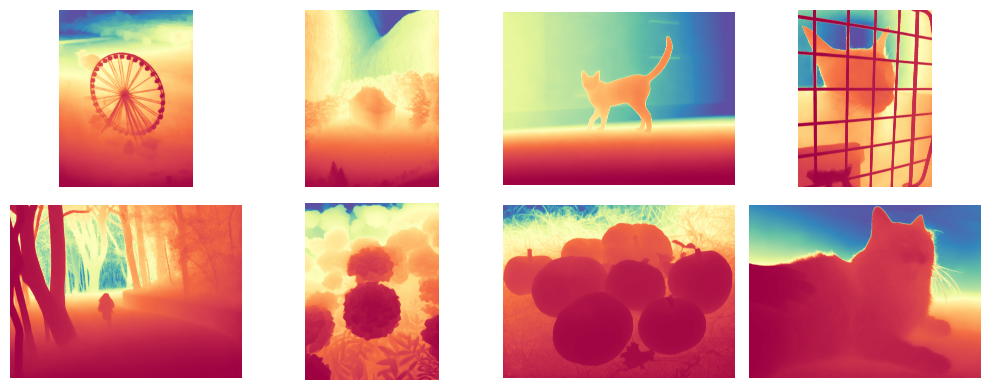

In [14]:
%matplotlib inline

# @title 2.2.5 Display predictions

output_images_colored  = glob(os.path.join(output_dir_color, "*"))
display_images(output_images_colored)


## 🚀 3 Evaluation

In [74]:
###### Load NYUv2 (used in the original paper) using HF (on-the-fly)

# 1. Install dependencies
!pip install -q datasets[vision] h5py aiohttp     # add aiohttp for ClientTimeout

# 2. In Colab, load the dataset
from datasets import load_dataset
from aiohttp import ClientTimeout

# aiohttp’s timeout wrapper
timeout = ClientTimeout(total=3600)   # 1 hour

nyu = load_dataset(
    "0jl/NYUv2",
    trust_remote_code=True,
    split="train",
    storage_options={"client_kwargs": {"timeout": timeout}},  # avoid timeouts
)



ERROR: Operation cancelled by user


In [75]:
from datasets import config
print(config.HF_DATASETS_CACHE)  # e.g. /root/.cache/huggingface/datasets

/root/.cache/huggingface/datasets


In [76]:
!ls /root/.cache/huggingface/datasets/


0jl___ny_uv2
downloads
_root_.cache_huggingface_datasets_0jl___ny_uv2_default_1.2.1_7c259efabaee962ce220bf9a51222ba1b9f0e8784b34827d0d2de751f4640bdd.lock


In [77]:
import numpy as np
import torch
from torch.utils.data import DataLoader

ex0 = nyu[0]

# RGB → NumPy
rgb_np = np.array(ex0["image"])
print("RGB shape (H, W, C):", rgb_np.shape)

# depth → NumPy
depth_arr = np.array(ex0["depth"], dtype=np.float32)
print("Depth shape (H, W):", depth_arr.shape)

# semantic label → NumPy
lbl_arr = np.array(ex0["label"], dtype=np.int64)
print("Semantic label shape:", lbl_arr.shape)

# scene strings
print("Scene name:", ex0["scene"])
print("Scene type:", ex0["scene_type"])

# accelData → NumPy
accel_arr = np.array(ex0["accelData"], dtype=np.float32)
print("Accel data shape:", accel_arr.shape)

# Build a small DataLoader for batches
def collate_fn(batch):
    images = torch.stack([
        torch.from_numpy(np.array(item["image"])).permute(2,0,1).float()
        for item in batch
    ])
    depths = torch.stack([
        torch.from_numpy(np.array(item["depth"], dtype=np.float32))[None,...]
        for item in batch
    ])
    return {"images": images, "depths": depths}

dl = DataLoader(nyu, batch_size=4, collate_fn=collate_fn, shuffle=True)
batch = next(iter(dl))
print("Batch images:", batch["images"].shape)
print("Batch depths:", batch["depths"].shape)


RGB shape (H, W, C): (480, 640, 3)
Depth shape (H, W): (480, 640)
Semantic label shape: (480, 640)
Scene name: kitchen_0004
Scene type: kitchen
Accel data shape: (4,)
Batch images: torch.Size([4, 3, 480, 640])
Batch depths: torch.Size([4, 1, 480, 640])


In [78]:
!ls config/dataset

data_diode_all.yaml	    data_kitti_val.yaml    dataset_val.yaml
data_eth3d.yaml		    data_nyu_test.yaml	   dataset_vis.yaml
data_hypersim_train.yaml    data_nyu_train.yaml    data_vkitti_train.yaml
data_hypersim_val.yaml	    data_scannet_val.yaml  data_vkitti_val.yaml
data_kitti_eigen_test.yaml  dataset_train.yaml


In [79]:
from PIL import Image
import numpy as np
import torch
from tqdm.auto import tqdm
from src.util.metric import (
    abs_relative_difference,
    squared_relative_difference,
    rmse_linear,
    rmse_log,
    log10,
    delta1_acc,
    delta2_acc,
    delta3_acc,
    i_rmse,
    silog_rmse,
)

# 0. Device & pipeline setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = MarigoldPipeline.from_pretrained("prs-eth/marigold-v1-0", torch_dtype=torch.float16)
pipe = pipe.to(device)

# 1. Prepare metric containers
metrics = [
    "abs_rel", "sq_rel", "rmse", "rmse_log", "log10",
    "d1", "d2", "d3", "i_rmse", "silog",
]
results = {m: [] for m in metrics}


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [85]:
import numpy as np
from tqdm.auto import tqdm

# (Optionally) only sample the first 100 examples for speed:
sample_idxs = list(range(min(100, len(nyu))))

all_mins = []
all_maxs = []
for i in tqdm(sample_idxs, desc="Gathering NYUv2 stats"):
    d = np.array(nyu[i]["depth"], dtype=np.float32)
    valid = d > 0
    all_mins.append(d[valid].min())
    all_maxs.append(d.max())

min_depth = float(min(all_mins))
max_depth = float(max(all_maxs))
print(f"Estimated NYUv2 depth range: {min_depth:.3f}m – {max_depth:.3f}m")


Gathering NYUv2 stats:   0%|          | 0/100 [00:00<?, ?it/s]

Estimated NYUv2 depth range: 0.713m – 9.993m


In [88]:
from src.util.alignment import align_depth_least_square
import torch, numpy as np
from tqdm.auto import tqdm

# ─── use the values you just computed ───
# (you ran the HF‐scan and got, for example:)
min_depth = 0.713  # replace with your printed value
max_depth = 9.993  # replace with your printed value

# reset your results container if you haven’t already
metrics = ["abs_rel","sq_rel","rmse","rmse_log","log10","d1","d2","d3","i_rmse","silog"]
results = {m: [] for m in metrics}

# 2. Evaluate first 15 HF‐loaded NYU examples
for idx in tqdm(range(15), desc="Eval NYU"):
    ex = nyu[idx]

    # GT and mask
    gt = np.array(ex["depth"], dtype=np.float32)
    mask = gt > 0

    # Inference
    out = pipe(
        ex["image"],
        denoising_steps=50,
        ensemble_size=10,
        color_map=None,
        show_progress_bar=True,
    )
    pred = out.depth_np  # [H, W] in [0,1]

    # ─── DENORMALIZE TO METERS ───
    pred_norm = pred.astype(np.float32)
    pred_m    = pred_norm * (max_depth - min_depth) + min_depth

    # ─── ALIGNMENT STEP ───
    gt_f   = gt.astype(np.float32)
    pred_f = pred_m
    pred_aligned, scale, shift = align_depth_least_square(
        gt_arr            = gt_f,
        pred_arr          = pred_f,
        valid_mask_arr    = mask,
        return_scale_shift=True,
    )
    pred = pred_aligned

    # Torch conversion
    gt_t   = torch.from_numpy(gt_f)[None, ...].to(device)
    pred_t = torch.from_numpy(pred)[None, ...].to(device)
    mask_t = torch.from_numpy(mask)[None, ...].to(device)

    # Compute all metrics
    results["abs_rel"].append(abs_relative_difference(pred_t, gt_t, mask_t).item())
    results["sq_rel"].append(squared_relative_difference(pred_t, gt_t, mask_t).item())
    results["rmse"].append(rmse_linear(pred_t, gt_t, mask_t).item())
    results["rmse_log"].append(rmse_log(pred_t, gt_t, mask_t).item())
    results["log10"].append(log10(pred_t, gt_t, mask_t).item())
    results["d1"].append(delta1_acc(pred_t, gt_t, mask_t).item())
    results["d2"].append(delta2_acc(pred_t, gt_t, mask_t).item())
    results["d3"].append(delta3_acc(pred_t, gt_t, mask_t).item())
    results["i_rmse"].append(i_rmse(pred_t, gt_t, mask_t).item())
    results["silog"].append(silog_rmse(pred_t, gt_t, mask_t).item())

# 3. Print averages
print("\nNYU-v2 (first 15) metrics:")
for name in metrics:
    print(f" {name:7s}: {np.mean(results[name]):.4f}")


Eval NYU:   0%|          | 0/15 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:619: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx


  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/2 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/50 [00:00<?, ?it/s]


NYU-v2 (first 15) metrics:
 abs_rel: 0.0856
 sq_rel : 0.0587
 rmse   : 0.3250
 rmse_log: 0.1247
 log10  : 0.0343
 d1     : 0.9302
 d2     : 0.9803
 d3     : 0.9948
 i_rmse : 0.0621
 silog  : 12.4014
